In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ = pd.read_csv("https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv", index_col=0)
df_.head()

,全国地方公共団体コード,都道府県名,市区町村名,公表_年月日,曜日,発症_年月日,患者_居住地,患者_年代,患者_性別,患者_属性,患者_状態,患者_症状,患者_渡航歴の有無フラグ,備考,退院済フラグ
No,,,,,,,,,,,,,,,
1,130001,東京都,NaN,2020-01-24,金,NaN,湖北省武漢市,40代,男性,NaN,NaN,NaN,NaN,NaN,1.0
2,130001,東京都,NaN,2020-01-25,土,NaN,湖北省武漢市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
3,130001,東京都,NaN,2020-01-30,木,NaN,湖南省長沙市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
4,130001,東京都,NaN,2020-02-13,木,NaN,都内,70代,男性,NaN,NaN,NaN,NaN,NaN,NaN
5,130001,東京都,NaN,2020-02-14,金,NaN,都内,50代,女性,NaN,NaN,NaN,NaN,NaN,1.0


In [3]:
# 年月日で集計
s = df_['公表_年月日'].value_counts().sort_index()

df = pd.DataFrame({'date':pd.to_datetime(s.index), 'confirmed':s})

# 報告がない日は0埋めしておく
df = pd.merge(pd.DataFrame({'date': pd.date_range(df.iloc[0]['date'],
                                                  df.iloc[-1]['date'])}),
              df, how='left')
df['confirmed'] = df['confirmed'].fillna(0)
df = df.set_index('date', drop=False)

df.head()

,date,confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,1.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0


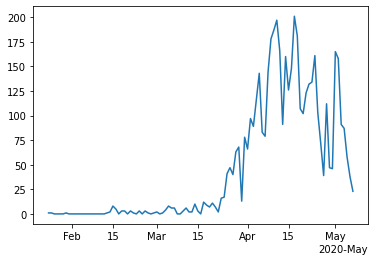

In [4]:
# 感染者数の推移をプロット

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.clear()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df['date'], df['confirmed'])

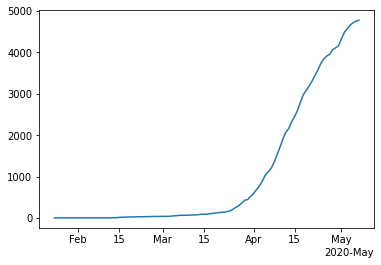

In [5]:
# 感染者数の累計をプロット

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.clear()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df['date'], df['confirmed'].cumsum())

In [6]:
# AICが最小となるSARIMAモデルをグリッドサーチ

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

best_fit = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['confirmed'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if best_fit == None:
                best_fit = results
            elif results.aic < best_fit.aic:
                best_fit = results
        except: 
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 7) - AIC:1196.9276101932617
SARIMAX(0, 0, 0)x(0, 0, 1, 7) - AIC:1052.1056280530383
SARIMAX(0, 0, 0)x(0, 0, 2, 7) - AIC:935.5950993159344
SARIMAX(0, 0, 0)x(0, 1, 0, 7) - AIC:963.4236017604513
SARIMAX(0, 0, 0)x(0, 1, 1, 7) - AIC:900.0998953380872
SARIMAX(0, 0, 0)x(0, 1, 2, 7) - AIC:834.5693687057143
SARIMAX(0, 0, 0)x(0, 2, 0, 7) - AIC:940.8196660828542
SARIMAX(0, 0, 0)x(0, 2, 1, 7) - AIC:848.9537773611319
SARIMAX(0, 0, 0)x(0, 2, 2, 7) - AIC:782.7943182285518
SARIMAX(0, 0, 0)x(1, 0, 0, 7) - AIC:973.63420324536
SARIMAX(0, 0, 0)x(1, 0, 1, 7) - AIC:963.1826392342623
SARIMAX(0, 0, 0)x(1, 0, 2, 7) - AIC:895.557381653991
SARIMAX(0, 0, 0)x(1, 1, 0, 7) - AIC:908.514510114016
SARIMAX(0, 0, 0)x(1, 1, 1, 7) - AIC:901.5558959403686
SARIMAX(0, 0, 0)x(1, 1, 2, 7) - AIC:830.9122724199552
SARIMAX(0, 0, 0)x(1, 2, 0, 7) - AIC:868.000518482078
SARIMAX(0, 0, 0)x(1, 2, 1, 7) - AIC:848.9049887997387
SARIMAX(0, 0, 0)x(1, 2, 2, 7) - AIC:784.7933150850951
SARIMAX(0, 0, 0)x(2, 0, 0, 7) -

SARIMAX(0, 1, 2)x(1, 2, 2, 7) - AIC:696.6756203129866
SARIMAX(0, 1, 2)x(2, 0, 0, 7) - AIC:832.7193869598483
SARIMAX(0, 1, 2)x(2, 0, 1, 7) - AIC:825.4794570219805
SARIMAX(0, 1, 2)x(2, 0, 2, 7) - AIC:801.8372113834411
SARIMAX(0, 1, 2)x(2, 1, 0, 7) - AIC:773.0033776435771
SARIMAX(0, 1, 2)x(2, 1, 1, 7) - AIC:771.4979408909453
SARIMAX(0, 1, 2)x(2, 1, 2, 7) - AIC:748.8057841483575
SARIMAX(0, 1, 2)x(2, 2, 0, 7) - AIC:739.5811963501556
SARIMAX(0, 1, 2)x(2, 2, 1, 7) - AIC:728.161373546104
SARIMAX(0, 1, 2)x(2, 2, 2, 7) - AIC:698.6707445779097
SARIMAX(0, 2, 0)x(0, 0, 0, 7) - AIC:1056.3791766910954
SARIMAX(0, 2, 0)x(0, 0, 1, 7) - AIC:991.6835395001946
SARIMAX(0, 2, 0)x(0, 0, 2, 7) - AIC:900.3732390017392
SARIMAX(0, 2, 0)x(0, 1, 0, 7) - AIC:1030.1529531743247
SARIMAX(0, 2, 0)x(0, 1, 1, 7) - AIC:922.8422975884286
SARIMAX(0, 2, 0)x(0, 1, 2, 7) - AIC:852.4284654716187
SARIMAX(0, 2, 0)x(0, 2, 0, 7) - AIC:1059.338936161697
SARIMAX(0, 2, 0)x(0, 2, 1, 7) - AIC:905.7058204855896
SARIMAX(0, 2, 0)x(0, 2, 2, 

SARIMAX(1, 0, 2)x(0, 2, 1, 7) - AIC:795.9053148064186
SARIMAX(1, 0, 2)x(0, 2, 2, 7) - AIC:723.6600331073365
SARIMAX(1, 0, 2)x(1, 0, 0, 7) - AIC:905.3558249357983
SARIMAX(1, 0, 2)x(1, 0, 1, 7) - AIC:886.8132014797557
SARIMAX(1, 0, 2)x(1, 0, 2, 7) - AIC:821.5761062099042
SARIMAX(1, 0, 2)x(1, 1, 0, 7) - AIC:833.7981769648147
SARIMAX(1, 0, 2)x(1, 1, 1, 7) - AIC:811.3238215452875
SARIMAX(1, 0, 2)x(1, 1, 2, 7) - AIC:755.3700898361532
SARIMAX(1, 0, 2)x(1, 2, 0, 7) - AIC:798.1104245232636
SARIMAX(1, 0, 2)x(1, 2, 1, 7) - AIC:773.5271555941364
SARIMAX(1, 0, 2)x(1, 2, 2, 7) - AIC:705.7264111279162
SARIMAX(1, 0, 2)x(2, 0, 0, 7) - AIC:833.3186373165386
SARIMAX(1, 0, 2)x(2, 0, 1, 7) - AIC:825.5907180194552
SARIMAX(1, 0, 2)x(2, 0, 2, 7) - AIC:810.326225906581
SARIMAX(1, 0, 2)x(2, 1, 0, 7) - AIC:773.2862130667424
SARIMAX(1, 0, 2)x(2, 1, 1, 7) - AIC:771.7037372317932
SARIMAX(1, 0, 2)x(2, 1, 2, 7) - AIC:757.3694035050962
SARIMAX(1, 0, 2)x(2, 2, 0, 7) - AIC:738.5634576269327
SARIMAX(1, 0, 2)x(2, 2, 1, 7)

SARIMAX(1, 2, 1)x(2, 2, 1, 7) - AIC:723.6469730188206
SARIMAX(1, 2, 1)x(2, 2, 2, 7) - AIC:710.8239059499547
SARIMAX(1, 2, 2)x(0, 0, 0, 7) - AIC:950.7594701132429
SARIMAX(1, 2, 2)x(0, 0, 1, 7) - AIC:896.8798053259449
SARIMAX(1, 2, 2)x(0, 0, 2, 7) - AIC:808.7276927213331
SARIMAX(1, 2, 2)x(0, 1, 0, 7) - AIC:892.9500364896112
SARIMAX(1, 2, 2)x(0, 1, 1, 7) - AIC:816.7094029793495
SARIMAX(1, 2, 2)x(0, 1, 2, 7) - AIC:758.634967139689
SARIMAX(1, 2, 2)x(0, 2, 0, 7) - AIC:906.0251264320198
SARIMAX(1, 2, 2)x(0, 2, 1, 7) - AIC:788.2871673039477
SARIMAX(1, 2, 2)x(0, 2, 2, 7) - AIC:709.9568858086573
SARIMAX(1, 2, 2)x(1, 0, 0, 7) - AIC:905.857383610649
SARIMAX(1, 2, 2)x(1, 0, 1, 7) - AIC:885.0219041955021
SARIMAX(1, 2, 2)x(1, 0, 2, 7) - AIC:817.0059897291045
SARIMAX(1, 2, 2)x(1, 1, 0, 7) - AIC:826.023633949372
SARIMAX(1, 2, 2)x(1, 1, 1, 7) - AIC:804.3595740447929
SARIMAX(1, 2, 2)x(1, 1, 2, 7) - AIC:746.8154487492058
SARIMAX(1, 2, 2)x(1, 2, 0, 7) - AIC:793.5904394907677
SARIMAX(1, 2, 2)x(1, 2, 1, 7) -

SARIMAX(2, 1, 1)x(1, 2, 1, 7) - AIC:773.1538561214012
SARIMAX(2, 1, 1)x(1, 2, 2, 7) - AIC:707.2244676659957
SARIMAX(2, 1, 1)x(2, 0, 0, 7) - AIC:816.3700773802718
SARIMAX(2, 1, 1)x(2, 0, 1, 7) - AIC:810.9216542999584
SARIMAX(2, 1, 1)x(2, 0, 2, 7) - AIC:812.4996095301049
SARIMAX(2, 1, 1)x(2, 1, 0, 7) - AIC:757.5613571931301
SARIMAX(2, 1, 1)x(2, 1, 1, 7) - AIC:756.7773822378093
SARIMAX(2, 1, 1)x(2, 1, 2, 7) - AIC:758.1171902828937
SARIMAX(2, 1, 1)x(2, 2, 0, 7) - AIC:723.6329404688051
SARIMAX(2, 1, 1)x(2, 2, 1, 7) - AIC:712.0207175261592
SARIMAX(2, 1, 1)x(2, 2, 2, 7) - AIC:709.0535505439186
SARIMAX(2, 1, 2)x(0, 0, 0, 7) - AIC:953.8307827547353
SARIMAX(2, 1, 2)x(0, 0, 1, 7) - AIC:891.3267663039959
SARIMAX(2, 1, 2)x(0, 0, 2, 7) - AIC:813.9993236700162
SARIMAX(2, 1, 2)x(0, 1, 0, 7) - AIC:900.7650044931208
SARIMAX(2, 1, 2)x(0, 1, 1, 7) - AIC:816.9626122100442
SARIMAX(2, 1, 2)x(0, 1, 2, 7) - AIC:758.962196432838
SARIMAX(2, 1, 2)x(0, 2, 0, 7) - AIC:911.5163804986823
SARIMAX(2, 1, 2)x(0, 2, 1, 7)

In [7]:
print(best_fit.summary().tables[0])

                                 Statespace Model Results                                
Dep. Variable:                         confirmed   No. Observations:                  105
Model:             SARIMAX(2, 2, 2)x(1, 2, 2, 7)   Log Likelihood                -339.754
Date:                           Fri, 08 May 2020   AIC                            695.507
Time:                                   09:48:15   BIC                            713.720
Sample:                               01-24-2020   HQIC                           702.758
                                    - 05-07-2020                                         
Covariance Type:                             opg                                         


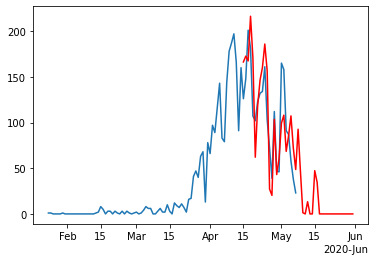

In [8]:
# 予測とプロット

pred = best_fit.predict('2020-04-15', '2020-05-31')

# 負の予測値は0にしておく
pred[pred < 0] = 0

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.clear()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df['date'], df['confirmed'])
ax.plot(pred.index, pred, 'r')

plt.savefig('plot.png')